In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io as io

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold, StratifiedKFold

import sys
from IPython.display import clear_output

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

def verbose(text):    
    clear_output(wait=True)    
    print(text)
    sys.stdout.flush() 
    
def errorfill(x, y, yerr, color=None, label=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, ymax, ymin, color=color, label=label, alpha=alpha_fill)
    return ax

In [4]:
baseMethods=['','baseline50','baseline100']
baseMethod=baseMethods[1]
filename = '/home/data/Project_ASD/' + os.environ["USER"]+'/ERPs-'+baseMethod+'.npz'
data = np.load(filename, allow_pickle=True)

In [5]:
ERPs = data['ERPs'] # n_subj, n_trtype, n_conds
subjects = data['subjects']
trialTypes=['item1','item2','target','invalidThird','correct','catch','easyFiller','ctrlFiller'];

In [ ]:
subj2exclude=['10056','12144','12360','1160','12005']
ind_ex = [i for i in range(len(subj2exclude)) if subj2exclude[i] in subjects[...,2].tolist()]
ERPs = np.delete(ERPs, ind_ex, axis=0)
subjects = np.delete(subjects, ind_ex, axis=0)
print('Removed '+str(len(ind_ex))+' subjects')


In [6]:
n_subj, n_trtype, n_conds = ERPs.shape
n_time, n_elec, _ = ERPs[0][0][0].shape

y=np.zeros(n_subj)
for s in range(n_subj):
    y[s]=int(subjects[s,0])
    
    
X_all = np.zeros((n_trtype,n_conds,n_subj,n_time,n_elec),dtype=object) 
#rcset
for k in range(n_conds):
    for r in range(n_trtype): 
        for s in range(n_subj):
            X_all[r,k,s]=np.squeeze(ERPs[s,r,k].mean(2, keepdims=True))
    

/home/jvacher/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/home/jvacher/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [11]:
n_time*n_elec

19520

In [13]:
# test_C

In [8]:
pca = PCA()
lr = 1
test_pca = np.arange(1,38,1)
test_C = np.logspace(-5, 0, 6)
n_C = test_C.shape[0]
n_pca = test_pca.shape[0]

if lr:
    clf = LogisticRegression(max_iter=5000, tol=1.0)
    param_grid = {
        'pca__n_components': test_pca,
        'clf__C': test_C,
    }
else:
    clf = LinearDiscriminantAnalysis(tol=1e-3)
    param_grid = {
        'pca__n_components': test_pca,
    }

# clf = QuadraticDiscriminantAnalysis(tol=1e-3)
pipe = Pipeline(steps=[('pca', pca), ('clf', clf)])
# search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=1, verbose=10)

In [14]:
search_all = np.zeros((n_trtype,n_conds), dtype=object)
for i in range(n_trtype):
    for j in range(n_conds):
        X = X_all[i,j].reshape(n_subj,n_time*n_elec)**2
        
        # using also squared signal improve performances
        #X = np.concatenate([X_all[i,j].reshape(n_participants,n_t*n_elec),
        #                   X_all[i,j].reshape(n_participants,n_t*n_elec)**2],
        #                   axis=1)
        
        X -= X.mean(0, keepdims=True)
        X /= X.std(0, keepdims=True)
        search_all[i,j] = GridSearchCV(pipe, param_grid,
                                       cv=5, n_jobs=15, verbose=0)
        search_all[i,j].fit(X, y);
        verbose('%i,%i'%(i,j))

1,3


Best parameter (CV score=0.639):
{'clf__C': 0.001, 'pca__n_components': 10}
Best parameter (CV score=0.853):
{'clf__C': 0.1, 'pca__n_components': 21}
Best parameter (CV score=0.708):
{'clf__C': 1.0, 'pca__n_components': 15}
Best parameter (CV score=0.706):
{'clf__C': 0.01, 'pca__n_components': 10}
Best parameter (CV score=0.614):
{'clf__C': 0.01, 'pca__n_components': 8}
Best parameter (CV score=0.681):
{'clf__C': 0.001, 'pca__n_components': 25}
Best parameter (CV score=0.639):
{'clf__C': 0.1, 'pca__n_components': 11}
Best parameter (CV score=0.614):
{'clf__C': 1.0, 'pca__n_components': 22}


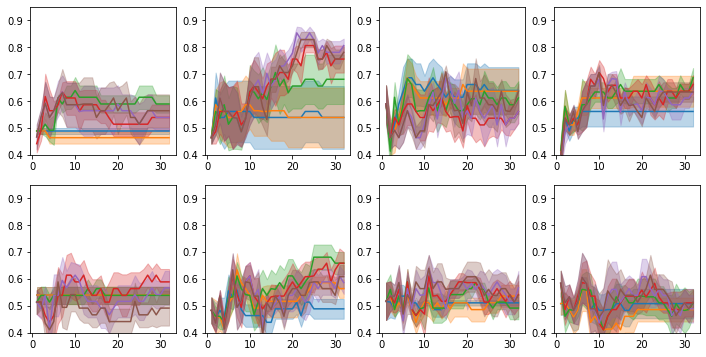

In [10]:
fig, ax = plt.subplots(n_trtype,n_conds,figsize=(12,6))
for i in range(n_trtype):
    for j in range(n_conds):
        print("Best parameter (CV score=%0.3f):" % search_all[i,j].best_score_)
        print(search_all[i,j].best_params_)
        if lr:
            for k in range(test_C.shape[0]):
                errorfill(test_pca,search_all[i,j].
                          cv_results_['mean_test_score']
                          .reshape(test_C.shape[0],test_pca.shape[0])[k].T,
                          search_all[i,j].cv_results_['std_test_score']
                          .reshape(test_C.shape[0],test_pca.shape[0])[k].T
                              /np.sqrt(5), ax=ax[i,j])
                ax[i,j].set_ylim(0.4,0.9)
                ax[i,j].title.set_text(trialTypes[i]+' '+'Cond'+str(j+1))
            
        else:
            errorfill(test_pca,search_all[i,j].cv_results_['mean_test_score'],
                      search_all[i,j].cv_results_['std_test_score']/np.sqrt(5),
                      ax=ax[i,j])    
        ax[i,j].set_ylim(0.4,0.95)
        


## Things to try
- Concatenate the conditions C1/C2/C3/C4
- Use non-linear methods like kernel methods (but we are already overfitting)
- Craft our own Quadratic Discriminant Analysis with diagonal cov matrices
- Use L1 penalty + logistic regression (highly relevant to find a relevant low
dimensional space)
- Use brute force PCA components selection (using all intervals [i,j])
- do channel selection and time windows selection

In [21]:
# pulling all conditions together (and time windows selection ??) 
Xct = np.zeros(n_trtype, dtype=object)
for r in range(n_trtype):
    Xct[i] = X_all[r].reshape(n_subj,n_time*n_elec*n_conds)


In [127]:
pca = PCA()
test_pca = np.array([32])#np.arange(5,38,5)#np.array([15,38])#
test_C = np.logspace(-3, 0, 41)
n_C = test_C.shape[0]
n_pca = test_pca.shape[0]

clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, tol=1.0)
param_grid = {
    'pca__n_components': test_pca,
    'clf__C': test_C,
}

# clf = QuadraticDiscriminantAnalysis(tol=1e-3)
pipe = Pipeline(steps=[('pca', pca), ('clf', clf)])
# search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=1, verbose=10)

In [128]:
search_l1_all = np.zeros(n_trtype, dtype=object)
for i in range(n_trtype):
    #X = Xct[i]**2
    # using also squared signal improve performances
    X = np.concatenate([Xct[i],Xct[i]**2], axis=1)

    X -= X.mean(0, keepdims=True)
    X /= X.std(0, keepdims=True)
    search_l1_all[i] = GridSearchCV(pipe, param_grid,
                                   cv=5, n_jobs=15, verbose=0)
    search_l1_all[i].fit(X, y);
    verbose('%i'%(i))

1


Best parameter (CV score=0.806):
{'clf__C': 0.1778279410038923, 'pca__n_components': 32}
Best parameter (CV score=0.683):
{'clf__C': 0.02238721138568339, 'pca__n_components': 32}


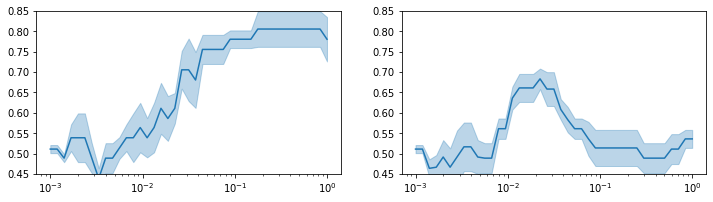

In [129]:
fig, ax = plt.subplots(1, n_trtype, figsize=(12,3))
for i in range(n_trtype):
    print("Best parameter (CV score=%0.3f):" % search_l1_all[i].best_score_)
    print(search_l1_all[i].best_params_)
    for k in range(test_pca.shape[0]):
        errorfill(test_C,search_l1_all[i].
                  cv_results_['mean_test_score']
                  .reshape(test_C.shape[0],test_pca.shape[0])[:,k],
                  search_l1_all[i].cv_results_['std_test_score']
                  .reshape(test_C.shape[0],test_pca.shape[0])[:,k]/np.sqrt(5),
                  ax=ax[i])

    ax[i].set_xscale('log')
    ax[i].set_ylim(0.45,0.85)
    ax[i].title.set_text(trialTypes[i])


20
10


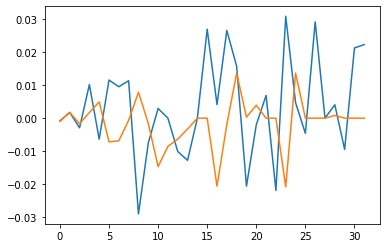

In [141]:
for i in range(n_trtype):
    #print(np.abs(search_l1_all[i].best_estimator_['clf'].coef_))
    print(np.sum(np.abs(search_l1_all[i].best_estimator_['clf'].coef_)>0.5e-2))
    plt.plot(search_l1_all[i].best_estimator_['clf'].coef_.T)

5
